In [1]:
#this code is for Amazon fine food review. Here we are trying to make a text summarizer.
'''Cell 1:'''
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
import re
from nltk.corpus import stopwords
import time
print('TensorFlow Version: {}'.format(tf.__version__))
import csv

TensorFlow Version: 1.1.0


In [6]:
'''cell 2:'''

reviews = pd.read_csv("D:/Documents/DataSets/amazon-fine-food-review/Reviews.csv")[:35173]
#reviews = pd.read_csv("E:/Shreyans/Data sets/amazon-fine-food-reviews/Reviews.csv")


'''Cell 3:'''
reviews.head()

,Id,ProductId,UserId,ProfileName,cHelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I had bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
reviews.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               1
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   1
Text                      0
dtype: int64

In [8]:
reviews.shape

(35173, 10)

In [9]:
'''Cell 5:'''

reviews = reviews.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time'], 1)
reviews = reviews.dropna()
demo_summary= reviews.drop(['Text'],1)
reviews = reviews.reset_index(drop=True)

'''Cell 6:'''
reviews.head()


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
reviews.isnull().sum()

Summary    0
Text       0
dtype: int64

In [11]:
reviews.shape

(35172, 2)

In [12]:
#print(reviews.Summary.value_counts(" "))
#print(reviews.Summary.value_counts())
print()
print(reviews.Summary.describe())
print()
print(reviews.Text.describe())


count          35172
unique         28194
top       Delicious!
freq             136
Name: Summary, dtype: object

count                                                 35172
unique                                                33043
top       Diamond Almonds<br />Almonds are a good source...
freq                                                     12
Name: Text, dtype: object


In [13]:

'''Cell 7: A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python'''
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [14]:
'''#Cell 8:'''
def clean_text(text, remove_stopwords):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

count_nan = 0
for summary in reviews.Summary:
    if str(summary) != 'nan':
        count_nan=count_nan+1

print(count_nan)

In [15]:
'''#Cell 9:'''
clean_summaries = []
for summary in reviews.Summary:
    clean_summaries.append(clean_text(str(summary), remove_stopwords=False))
print("Summaries are complete.")

clean_texts = []
for text in reviews.Text:
    clean_texts.append(clean_text(str(text), remove_stopwords=True))
print("Texts are complete.")


Summaries are complete.
Texts are complete.


In [16]:
for i in range(0,5):
    print("Text: ", clean_texts[i])
    print("Summaries: ",clean_summaries[i])
    print()


Text:  bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summaries:  good quality dog food

Text:  product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summaries:  not as advertised

Text:  confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summaries:   delight  says it all

Text:  looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal
Summaries:  cough medicine

Text:  great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
Summaries:  great taffy



In [17]:
'''#Cell 10:'''
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1
                
'''#Cell 11: Find the number of times each word was used and the size of the vocabulary'''
word_counts = {}

count_words(word_counts, clean_summaries)
count_words(word_counts, clean_texts)
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 37145


In [19]:
'''#Cell 12:'''
# Commented out because it won't load on Kaggle, so I'll replace it an empty list
embeddings_index = []

# Load Conceptnet Numberbatch's (CN) embeddings, similar to GloVe, but probably better 
# (https://github.com/commonsense/conceptnet-numberbatch)
embeddings_index = {}
#D:/Documents/DataSets for laptop
#E:/Shreyans/Data sets/numberbatch-en.txt
with open('D:/Documents/DataSets/numberbatch-en.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 417195


In [20]:
'''#Cell 13: Find the number of words that are missing from CN, and are used more than our threshold.'''
missing_words = 0
threshold = 20

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from CN:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from CN: 312
Percent of words that are missing from vocabulary: 0.84%


In [21]:
'''#Cell 14: Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe'''

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>","<EOS>","<GO>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(vocab_to_int))
print("Percent of words we will use: {}%".format(usage_ratio))

Total number of unique words: 37145
Number of words we will use: 25391
Percent of words we will use: 68.36%


In [22]:
'''#Cell 15:'''
# Need to use 300 for embedding dimensions to match CN's vectors.
embedding_dim = 300
nb_words = len(vocab_to_int)

# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in CN, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        #embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

25391


In [23]:
'''#Cell 16:'''
def convert_to_ints(text, word_count, unk_count, eos=False):
    '''Convert words in text to an integer.
       If word is not in vocab_to_int, use UNK's integer.
       Total the number of words and UNKs.
       Add EOS token to the end of texts'''
    ints = []
    for sentence in text:
        sentence_ints = []
        for word in sentence.split():
            word_count += 1
            if word in vocab_to_int:
                sentence_ints.append(vocab_to_int[word])
            else:
                sentence_ints.append(vocab_to_int["<UNK>"])
                unk_count += 1
        if eos:
            sentence_ints.append(vocab_to_int["<EOS>"])
        ints.append(sentence_ints)
    return ints, word_count, unk_count

In [24]:
'''#Cell 17:'''
# Apply convert_to_ints to clean_summaries and clean_texts
word_count = 0
unk_count = 0

int_summaries, word_count, unk_count = convert_to_ints(clean_summaries, word_count, unk_count)
int_texts, word_count, unk_count = convert_to_ints(clean_texts, word_count, unk_count, eos=True)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 1563100
Total number of UNKs in headlines: 23699
Percent of words that are UNK: 1.52%


In [25]:
'''#Cell 18:'''

def create_lengths(text):
    '''Create a data frame of the sentence lengths from a text'''
    lengths = []
    for sentence in text:
        lengths.append(len(sentence))
    return pd.DataFrame(lengths, columns=['counts'])

In [26]:
'''#Cell 19:'''

lengths_summaries = create_lengths(int_summaries)
lengths_texts = create_lengths(int_texts)

print("Summaries:")
print(lengths_summaries.describe())
print()
print("Texts:")
print(lengths_texts.describe())

Summaries:
             counts
count  35172.000000
mean       4.177101
std        2.648076
min        0.000000
25%        2.000000
50%        4.000000
75%        5.000000
max       30.000000

Texts:
             counts
count  35172.000000
mean      41.264500
std       39.651104
min        1.000000
25%       18.000000
50%       29.000000
75%       50.000000
max      783.000000


'''Cell 20:'''

#Inspect the length of texts
print(np.percentile(lengths_texts.counts, 90))
print(np.percentile(lengths_texts.counts, 95))
print(np.percentile(lengths_texts.counts, 99))

'''Cell 21:'''
#Inspect the length of summaries
print(np.percentile(lengths_summaries.counts, 90))
print(np.percentile(lengths_summaries.counts, 95))
print(np.percentile(lengths_summaries.counts, 99))

In [27]:
'''Cell 22:'''
def unk_counter(sentence):
    '''Counts the number of time UNK appears in a sentence.'''
    unk_count = 0
    for word in sentence:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
    return unk_count

In [28]:
'''Cell 23:'''
# Sort the summaries and texts by the length of the texts, shortest to longest
# Limit the length of summaries and texts based on the min and max ranges.
# Remove reviews that include too many UNKs

sorted_summaries = []
sorted_texts = []
max_text_length = 199 #84
max_summary_length = 13
min_length = 2
unk_text_limit = 100 # use 1
unk_summary_limit = 100 # use 0

for length in range(min(lengths_texts.counts), max_text_length): 
    for count, words in enumerate(int_summaries):
        if (len(int_summaries[count]) >= min_length and
            len(int_summaries[count]) <= max_summary_length and
            len(int_texts[count]) >= min_length and
            unk_counter(int_summaries[count]) <= unk_summary_limit and
            unk_counter(int_texts[count]) <= unk_text_limit and
            length == len(int_texts[count])
           ):
            sorted_summaries.append(int_summaries[count])
            sorted_texts.append(int_texts[count])
        
# Compare lengths to ensure they match
print(len(sorted_summaries))
print(len(sorted_texts))

31084
31084


<h1>Building the model

In [29]:
'''Cell 24:'''
def model_inputs():
    '''Create palceholders for inputs to the model'''
    
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    summary_length = tf.placeholder(tf.int32, (None,), name='summary_length')
    max_summary_length = tf.reduce_max(summary_length, name='max_dec_len')
    text_length = tf.placeholder(tf.int32, (None,), name='text_length')

    return input_data, targets, lr, keep_prob, summary_length, max_summary_length, text_length

In [30]:
'''Cell 25:'''
def process_encoding_input(target_data, vocab_to_int, batch_size):
    '''Remove the last word id from each batch and concat the <GO> to the begining of each batch'''
    
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    dec_input = tf.concat([tf.fill([batch_size, 1], vocab_to_int['<GO>']), ending], 1)

    return dec_input

In [31]:
'''Cell 26:'''
def encoding_layer(rnn_size, sequence_length, num_layers, rnn_inputs, keep_prob):
    '''Create the encoding layer'''
    
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer)):
            cell_fw = tf.contrib.rnn.LSTMCell(rnn_size,
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, 
                                                    input_keep_prob = keep_prob)

            cell_bw = tf.contrib.rnn.LSTMCell(rnn_size,
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, 
                                                    input_keep_prob = keep_prob)

            enc_output, enc_state = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                                    cell_bw, 
                                                                    rnn_inputs,
                                                                    sequence_length,
                                                                    dtype=tf.float32)
    # Join outputs since we are using a bidirectional RNN
    enc_output = tf.concat(enc_output,2)
    
    return enc_output, enc_state

In [32]:

'''Cell 27:'''
def training_decoding_layer(dec_embed_input, summary_length, dec_cell, initial_state, output_layer, 
                            vocab_size, max_summary_length):
    '''Create the training logits'''
    
    training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input,
                                                        sequence_length=summary_length,
                                                        time_major=False)

    training_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                       training_helper,
                                                       initial_state,
                                                       output_layer) 

    training_logits, _ = tf.contrib.seq2seq.dynamic_decode(training_decoder,
                                                           output_time_major=False,
                                                           impute_finished=True,
                                                           maximum_iterations=max_summary_length)
    return training_logits

In [33]:
'''Cell 28:'''
def inference_decoding_layer(embeddings, start_token, end_token, dec_cell, initial_state, output_layer,
                             max_summary_length, batch_size):
    '''Create the inference logits'''
    
    start_tokens = tf.tile(tf.constant([start_token], dtype=tf.int32), [batch_size], name='start_tokens')
    
    inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(embeddings,
                                                                start_tokens,
                                                                end_token)
                
    inference_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                        inference_helper,
                                                        initial_state,
                                                        output_layer)
                
    inference_logits, _ = tf.contrib.seq2seq.dynamic_decode(inference_decoder,
                                                            output_time_major=False,
                                                            impute_finished=True,
                                                            maximum_iterations=max_summary_length)
    
    return inference_logits

<h2>Applying Attention</h2>

In [34]:
'''Cell 29:'''
#output_units=12
def decoding_layer(dec_embed_input, embeddings, enc_output, enc_state, vocab_size, text_length, summary_length, 
                   max_summary_length, rnn_size, vocab_to_int, keep_prob, batch_size, num_layers):
    '''Create the decoding cell and attention for the training and inference decoding layers'''
    
    for layer in range(num_layers):
        with tf.variable_scope('decoder_{}'.format(layer)):
            lstm = tf.contrib.rnn.LSTMCell(rnn_size,
                                           initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            dec_cell = tf.contrib.rnn.DropoutWrapper(lstm, 
                                                     input_keep_prob = keep_prob)
    
    output_layer = Dense(vocab_size,
                         kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))
    
    #Attention Mechanism
    attn_mech = tf.contrib.seq2seq.BahdanauAttention(rnn_size,
                                                  enc_output,
                                                  text_length,
                                                  normalize=False,
                                                  name='BahdanauAttention')

    dec_cell = tf.contrib.seq2seq.DynamicAttentionWrapper(dec_cell,
                                                          attn_mech,
                                                          rnn_size)
            
    initial_state = tf.contrib.seq2seq.DynamicAttentionWrapperState(enc_state[0],
                                                                    _zero_state_tensors(rnn_size, 
                                                                                        batch_size, 
                                                                                        tf.float32)) 
    with tf.variable_scope("decode"):
        training_logits = training_decoding_layer(dec_embed_input, 
                                                  summary_length, 
                                                  dec_cell, 
                                                  initial_state,
                                                  output_layer,
                                                  vocab_size, 
                                                  max_summary_length)
    with tf.variable_scope("decode", reuse=True):
        inference_logits = inference_decoding_layer(embeddings,  
                                                    vocab_to_int['<GO>'], 
                                                    vocab_to_int['<EOS>'],
                                                    dec_cell, 
                                                    initial_state, 
                                                    output_layer,
                                                    max_summary_length,
                                                    batch_size)

    return training_logits, inference_logits

In [35]:
'''Cell 30:'''
def seq2seq_model(input_data, target_data, keep_prob, text_length, summary_length, max_summary_length, 
                  vocab_size, rnn_size, num_layers, vocab_to_int, batch_size):
    '''Use the previous functions to create the training and inference logits'''
    
    # Use Numberbatch's embeddings and the newly created ones as our embeddings
    embeddings = word_embedding_matrix
    
    enc_embed_input = tf.nn.embedding_lookup(embeddings, input_data)
    enc_output, enc_state = encoding_layer(rnn_size, text_length, num_layers, enc_embed_input, keep_prob)
    
    dec_input = process_encoding_input(target_data, vocab_to_int, batch_size)
    dec_embed_input = tf.nn.embedding_lookup(embeddings, dec_input)
    
    training_logits, inference_logits  = decoding_layer(dec_embed_input, 
                                                        embeddings,
                                                        enc_output,
                                                        enc_state, 
                                                        vocab_size, 
                                                        text_length, 
                                                        summary_length, 
                                                        max_summary_length,
                                                        rnn_size, 
                                                        vocab_to_int, 
                                                        keep_prob, 
                                                        batch_size,
                                                        num_layers)
    
    return training_logits, inference_logits

In [36]:
'''Cell 31:'''
def pad_sentence_batch(sentence_batch):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [vocab_to_int['<PAD>']] * (max_sentence - len(sentence)) for sentence in sentence_batch]

In [37]:
'''Cell 32:'''
def get_batches(summaries, texts, batch_size):
    """Batch summaries, texts, and the lengths of their sentences together"""
    for batch_i in range(0, len(texts)//batch_size):
        start_i = batch_i * batch_size
        summaries_batch = summaries[start_i:start_i + batch_size]
        texts_batch = texts[start_i:start_i + batch_size]
        pad_summaries_batch = np.array(pad_sentence_batch(summaries_batch))
        pad_texts_batch = np.array(pad_sentence_batch(texts_batch))
        
        # Need the lengths for the _lengths parameters
        pad_summaries_lengths = []
        for summary in pad_summaries_batch:
            pad_summaries_lengths.append(len(summary))
        
        pad_texts_lengths = []
        for text in pad_texts_batch:
            pad_texts_lengths.append(len(text))
        
        yield pad_summaries_batch, pad_texts_batch, pad_summaries_lengths, pad_texts_lengths

<h1>Training the Model

In [38]:
'''Cell 33:'''
# Set the Hyperparameters
epochs = 50 # use 100
batch_size = 64
rnn_size = 256
num_layers = 3
learning_rate = 0.008
keep_probability = 0.75

<h2>Building the graph

In [39]:
'''Cell 34:'''

train_graph = tf.Graph()
# Set the graph to default to ensure that it is ready for training
with train_graph.as_default():
    
    # Load the model inputs    
    input_data, targets, lr, keep_prob, summary_length, max_summary_length, text_length = model_inputs()

    # Create the training and inference logits
    training_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]),
                                                      targets, 
                                                      keep_prob,   
                                                      text_length,
                                                      summary_length,
                                                      max_summary_length,
                                                      len(vocab_to_int)+1,
                                                      rnn_size, 
                                                      num_layers, 
                                                      vocab_to_int,
                                                      batch_size)
    
    # Create tensors for the training logits and inference logits
    training_logits = tf.identity(training_logits.rnn_output, 'logits')
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')
    
    # Create the weights for sequence_loss
    masks = tf.sequence_mask(summary_length, max_summary_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)
print("Graph is built.")

Graph is built.


<h2> This module will train the above graph</h2>

In [40]:
# Train the Model
learning_rate_decay = 0.95
min_learning_rate = 0.0005
display_step = 5 # Check training loss after every 20 batches
stop_early = 0 
stop = 3 # If the update loss does not decrease in 3 consecutive update checks, stop training
per_epoch = 3 # Make 3 update checks per epoch
update_check = (len(sorted_texts)//batch_size//per_epoch)-1

update_loss = 0 
batch_loss = 0
summary_update_loss = [] # Record the update losses for saving improvements in the model


checkpoint = "./best_model.ckpt" 
#uncomment the above line for new training.

In [48]:
print("Training will Strat now.")
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    # If we want to continue training a previous session

    #loader = tf.train.import_meta_graph("C:/Users/shrey/OneDrive/Study/Bennett/Sem2/HPC/Project/amazon_fine_food_review_summarizer/best_model.ckpt.meta")
    #loader.restore(sess, checkpoint)
    
    #by commenting above 2 lines the code will start retrain the model. 
            
    for epoch_i in range(1, epochs+1):
        update_loss = 0
        batch_loss = 0
        for batch_i, (summaries_batch, texts_batch, summaries_lengths, texts_lengths) in enumerate(
                get_batches(sorted_summaries, sorted_texts, batch_size)):
            start_time = time.time()
            _, loss = sess.run(
                [train_op, cost],
                {input_data: texts_batch,
                 targets: summaries_batch,
                 lr: learning_rate,
                 summary_length: summaries_lengths,
                 text_length: texts_lengths,
                 keep_prob: keep_probability})

            batch_loss += loss
            update_loss += loss
            end_time = time.time()
            batch_time = end_time - start_time

            if batch_i % display_step == 0 and batch_i > 0:
                print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}, Seconds: {:>4.2f}'
                      .format(epoch_i,
                              epochs, 
                              batch_i, 
                              len(sorted_texts) // batch_size, 
                              batch_loss / display_step, 
                              batch_time*display_step))
                batch_loss = 0

            if batch_i % update_check == 0 and batch_i > 0:
                print("Average loss for this update:", round(update_loss/update_check,3))
                summary_update_loss.append(update_loss)
                
                # If the update loss is at a new minimum, save the model
                if update_loss <= min(summary_update_loss):
                    print('New Record!') 
                    stop_early = 0
                    saver = tf.train.Saver() 
                    saver.save(sess, checkpoint)

                else:
                    print("No Improvement.")
                    stop_early += 1
                    if stop_early == stop:
                        break
                update_loss = 0
            
        saver = tf.train.Saver() 
        saver.save(sess, checkpoint)

        # Reduce learning rate, but not below its minimum value
        learning_rate *= learning_rate_decay
        if learning_rate < min_learning_rate:
            learning_rate = min_learning_rate
        
        if stop_early == stop:
            print("Stopping Training.")
            break

print("Model Trained")

Training will Strat now.
Epoch   1/50 Batch    5/485 - Loss:  7.340, Seconds: 6.06
Epoch   1/50 Batch   10/485 - Loss:  3.060, Seconds: 7.13
Epoch   1/50 Batch   15/485 - Loss:  2.882, Seconds: 5.80
Epoch   1/50 Batch   20/485 - Loss:  2.630, Seconds: 7.45
Epoch   1/50 Batch   25/485 - Loss:  2.879, Seconds: 5.24
Epoch   1/50 Batch   30/485 - Loss:  2.645, Seconds: 7.55
Epoch   1/50 Batch   35/485 - Loss:  2.709, Seconds: 6.89
Epoch   1/50 Batch   40/485 - Loss:  2.786, Seconds: 5.47
Epoch   1/50 Batch   45/485 - Loss:  2.720, Seconds: 6.99
Epoch   1/50 Batch   50/485 - Loss:  2.644, Seconds: 7.91
Epoch   1/50 Batch   55/485 - Loss:  2.672, Seconds: 4.94
Epoch   1/50 Batch   60/485 - Loss:  2.701, Seconds: 5.02
Epoch   1/50 Batch   65/485 - Loss:  2.484, Seconds: 6.07
Epoch   1/50 Batch   70/485 - Loss:  2.375, Seconds: 6.73
Epoch   1/50 Batch   75/485 - Loss:  2.732, Seconds: 7.29
Epoch   1/50 Batch   80/485 - Loss:  2.705, Seconds: 7.36
Epoch   1/50 Batch   85/485 - Loss:  2.596, Sec

Epoch   2/50 Batch  210/485 - Loss:  2.086, Seconds: 9.25
Epoch   2/50 Batch  215/485 - Loss:  2.022, Seconds: 8.16
Epoch   2/50 Batch  220/485 - Loss:  2.002, Seconds: 8.77
Epoch   2/50 Batch  225/485 - Loss:  2.119, Seconds: 6.98
Epoch   2/50 Batch  230/485 - Loss:  2.017, Seconds: 8.91
Epoch   2/50 Batch  235/485 - Loss:  2.030, Seconds: 8.94
Epoch   2/50 Batch  240/485 - Loss:  2.266, Seconds: 6.59
Epoch   2/50 Batch  245/485 - Loss:  1.960, Seconds: 8.49
Epoch   2/50 Batch  250/485 - Loss:  1.963, Seconds: 9.78
Epoch   2/50 Batch  255/485 - Loss:  2.103, Seconds: 9.86
Epoch   2/50 Batch  260/485 - Loss:  2.245, Seconds: 9.13
Epoch   2/50 Batch  265/485 - Loss:  2.115, Seconds: 7.49
Epoch   2/50 Batch  270/485 - Loss:  2.160, Seconds: 8.61
Epoch   2/50 Batch  275/485 - Loss:  2.005, Seconds: 9.39
Epoch   2/50 Batch  280/485 - Loss:  2.015, Seconds: 9.42
Epoch   2/50 Batch  285/485 - Loss:  2.181, Seconds: 8.81
Epoch   2/50 Batch  290/485 - Loss:  2.010, Seconds: 9.60
Epoch   2/50 B

Epoch   3/50 Batch  415/485 - Loss:  2.186, Seconds: 13.18
Epoch   3/50 Batch  420/485 - Loss:  2.207, Seconds: 13.33
Epoch   3/50 Batch  425/485 - Loss:  2.109, Seconds: 12.21
Epoch   3/50 Batch  430/485 - Loss:  2.152, Seconds: 13.03
Epoch   3/50 Batch  435/485 - Loss:  2.234, Seconds: 13.41
Epoch   3/50 Batch  440/485 - Loss:  2.284, Seconds: 13.59
Epoch   3/50 Batch  445/485 - Loss:  2.235, Seconds: 13.86
Epoch   3/50 Batch  450/485 - Loss:  2.258, Seconds: 13.51
Epoch   3/50 Batch  455/485 - Loss:  2.156, Seconds: 14.79
Epoch   3/50 Batch  460/485 - Loss:  2.460, Seconds: 14.65
Epoch   3/50 Batch  465/485 - Loss:  2.353, Seconds: 16.76
Epoch   3/50 Batch  470/485 - Loss:  2.432, Seconds: 17.83
Epoch   3/50 Batch  475/485 - Loss:  2.419, Seconds: 19.32
Epoch   3/50 Batch  480/485 - Loss:  2.494, Seconds: 19.81
Average loss for this update: 2.143
No Improvement.
Epoch   4/50 Batch    5/485 - Loss:  2.109, Seconds: 6.30
Epoch   4/50 Batch   10/485 - Loss:  1.634, Seconds: 6.90
Epoch 

Epoch   5/50 Batch  140/485 - Loss:  1.684, Seconds: 7.13
Epoch   5/50 Batch  145/485 - Loss:  1.496, Seconds: 7.83
Epoch   5/50 Batch  150/485 - Loss:  1.598, Seconds: 7.15
Epoch   5/50 Batch  155/485 - Loss:  1.597, Seconds: 7.83
Epoch   5/50 Batch  160/485 - Loss:  1.467, Seconds: 6.58
Average loss for this update: 1.559
New Record!
Epoch   5/50 Batch  165/485 - Loss:  1.618, Seconds: 7.33
Epoch   5/50 Batch  170/485 - Loss:  1.654, Seconds: 8.24
Epoch   5/50 Batch  175/485 - Loss:  1.456, Seconds: 8.56
Epoch   5/50 Batch  180/485 - Loss:  1.523, Seconds: 8.73
Epoch   5/50 Batch  185/485 - Loss:  1.603, Seconds: 7.50
Epoch   5/50 Batch  190/485 - Loss:  1.581, Seconds: 9.21
Epoch   5/50 Batch  195/485 - Loss:  1.573, Seconds: 7.46
Epoch   5/50 Batch  200/485 - Loss:  1.694, Seconds: 7.42
Epoch   5/50 Batch  205/485 - Loss:  1.641, Seconds: 7.00
Epoch   5/50 Batch  210/485 - Loss:  1.657, Seconds: 9.28
Epoch   5/50 Batch  215/485 - Loss:  1.616, Seconds: 8.31
Epoch   5/50 Batch  220/

Epoch   6/50 Batch  345/485 - Loss:  1.752, Seconds: 10.11
Epoch   6/50 Batch  350/485 - Loss:  1.838, Seconds: 9.84
Epoch   6/50 Batch  355/485 - Loss:  1.694, Seconds: 10.66
Epoch   6/50 Batch  360/485 - Loss:  1.716, Seconds: 11.37
Epoch   6/50 Batch  365/485 - Loss:  1.752, Seconds: 11.52
Epoch   6/50 Batch  370/485 - Loss:  1.873, Seconds: 10.95
Epoch   6/50 Batch  375/485 - Loss:  1.835, Seconds: 10.53
Epoch   6/50 Batch  380/485 - Loss:  1.773, Seconds: 11.70
Epoch   6/50 Batch  385/485 - Loss:  1.786, Seconds: 10.70
Epoch   6/50 Batch  390/485 - Loss:  1.658, Seconds: 11.54
Epoch   6/50 Batch  395/485 - Loss:  1.903, Seconds: 11.02
Epoch   6/50 Batch  400/485 - Loss:  1.859, Seconds: 11.79
Epoch   6/50 Batch  405/485 - Loss:  1.799, Seconds: 11.86
Epoch   6/50 Batch  410/485 - Loss:  1.773, Seconds: 12.22
Epoch   6/50 Batch  415/485 - Loss:  1.897, Seconds: 13.04
Epoch   6/50 Batch  420/485 - Loss:  1.903, Seconds: 13.16
Epoch   6/50 Batch  425/485 - Loss:  1.805, Seconds: 12.2

Epoch   8/50 Batch   70/485 - Loss:  1.293, Seconds: 6.64
Epoch   8/50 Batch   75/485 - Loss:  1.517, Seconds: 7.19
Epoch   8/50 Batch   80/485 - Loss:  1.394, Seconds: 7.20
Epoch   8/50 Batch   85/485 - Loss:  1.389, Seconds: 6.88
Epoch   8/50 Batch   90/485 - Loss:  1.419, Seconds: 6.28
Epoch   8/50 Batch   95/485 - Loss:  1.386, Seconds: 6.77
Epoch   8/50 Batch  100/485 - Loss:  1.311, Seconds: 8.61
Epoch   8/50 Batch  105/485 - Loss:  1.347, Seconds: 8.62
Epoch   8/50 Batch  110/485 - Loss:  1.333, Seconds: 7.53
Epoch   8/50 Batch  115/485 - Loss:  1.470, Seconds: 8.12
Epoch   8/50 Batch  120/485 - Loss:  1.331, Seconds: 7.48
Epoch   8/50 Batch  125/485 - Loss:  1.442, Seconds: 7.15
Epoch   8/50 Batch  130/485 - Loss:  1.373, Seconds: 6.47
Epoch   8/50 Batch  135/485 - Loss:  1.386, Seconds: 8.15
Epoch   8/50 Batch  140/485 - Loss:  1.509, Seconds: 7.11
Epoch   8/50 Batch  145/485 - Loss:  1.379, Seconds: 7.76
Epoch   8/50 Batch  150/485 - Loss:  1.438, Seconds: 7.26
Epoch   8/50 B

Epoch   9/50 Batch  280/485 - Loss:  1.403, Seconds: 9.60
Epoch   9/50 Batch  285/485 - Loss:  1.564, Seconds: 9.11
Epoch   9/50 Batch  290/485 - Loss:  1.435, Seconds: 9.88
Epoch   9/50 Batch  295/485 - Loss:  1.331, Seconds: 10.56
Epoch   9/50 Batch  300/485 - Loss:  1.347, Seconds: 10.48
Epoch   9/50 Batch  305/485 - Loss:  1.482, Seconds: 10.10
Epoch   9/50 Batch  310/485 - Loss:  1.527, Seconds: 8.80
Epoch   9/50 Batch  315/485 - Loss:  1.540, Seconds: 10.04
Epoch   9/50 Batch  320/485 - Loss:  1.532, Seconds: 10.40
Average loss for this update: 1.422
No Improvement.
Epoch   9/50 Batch  325/485 - Loss:  1.636, Seconds: 8.75
Epoch   9/50 Batch  330/485 - Loss:  1.374, Seconds: 11.38
Epoch   9/50 Batch  335/485 - Loss:  1.599, Seconds: 10.28
Epoch   9/50 Batch  340/485 - Loss:  1.536, Seconds: 9.81
Epoch   9/50 Batch  345/485 - Loss:  1.579, Seconds: 10.62
Epoch   9/50 Batch  350/485 - Loss:  1.642, Seconds: 10.43
Epoch   9/50 Batch  355/485 - Loss:  1.531, Seconds: 10.72
Epoch   9/

Epoch  11/50 Batch    5/485 - Loss:  1.694, Seconds: 6.57
Epoch  11/50 Batch   10/485 - Loss:  1.227, Seconds: 7.26
Epoch  11/50 Batch   15/485 - Loss:  1.189, Seconds: 6.00
Epoch  11/50 Batch   20/485 - Loss:  1.144, Seconds: 8.23
Epoch  11/50 Batch   25/485 - Loss:  1.261, Seconds: 5.59
Epoch  11/50 Batch   30/485 - Loss:  1.155, Seconds: 7.98
Epoch  11/50 Batch   35/485 - Loss:  1.230, Seconds: 7.33
Epoch  11/50 Batch   40/485 - Loss:  1.267, Seconds: 5.65
Epoch  11/50 Batch   45/485 - Loss:  1.221, Seconds: 7.18
Epoch  11/50 Batch   50/485 - Loss:  1.204, Seconds: 7.89
Epoch  11/50 Batch   55/485 - Loss:  1.181, Seconds: 4.95
Epoch  11/50 Batch   60/485 - Loss:  1.198, Seconds: 5.10
Epoch  11/50 Batch   65/485 - Loss:  1.168, Seconds: 6.22
Epoch  11/50 Batch   70/485 - Loss:  1.118, Seconds: 7.02
Epoch  11/50 Batch   75/485 - Loss:  1.275, Seconds: 7.48
Epoch  11/50 Batch   80/485 - Loss:  1.196, Seconds: 7.37
Epoch  11/50 Batch   85/485 - Loss:  1.158, Seconds: 6.98
Epoch  11/50 B

Epoch  12/50 Batch  215/485 - Loss:  1.271, Seconds: 8.54
Epoch  12/50 Batch  220/485 - Loss:  1.254, Seconds: 9.22
Epoch  12/50 Batch  225/485 - Loss:  1.265, Seconds: 7.32
Epoch  12/50 Batch  230/485 - Loss:  1.262, Seconds: 9.22
Epoch  12/50 Batch  235/485 - Loss:  1.270, Seconds: 9.21
Epoch  12/50 Batch  240/485 - Loss:  1.349, Seconds: 6.84
Epoch  12/50 Batch  245/485 - Loss:  1.261, Seconds: 8.77
Epoch  12/50 Batch  250/485 - Loss:  1.263, Seconds: 10.08
Epoch  12/50 Batch  255/485 - Loss:  1.336, Seconds: 10.02
Epoch  12/50 Batch  260/485 - Loss:  1.321, Seconds: 9.54
Epoch  12/50 Batch  265/485 - Loss:  1.294, Seconds: 7.68
Epoch  12/50 Batch  270/485 - Loss:  1.349, Seconds: 8.96
Epoch  12/50 Batch  275/485 - Loss:  1.286, Seconds: 9.67
Epoch  12/50 Batch  280/485 - Loss:  1.281, Seconds: 9.71
Epoch  12/50 Batch  285/485 - Loss:  1.418, Seconds: 9.07
Epoch  12/50 Batch  290/485 - Loss:  1.309, Seconds: 9.84
Epoch  12/50 Batch  295/485 - Loss:  1.190, Seconds: 10.47
Epoch  12/5

Epoch  13/50 Batch  420/485 - Loss:  1.519, Seconds: 14.22
Epoch  13/50 Batch  425/485 - Loss:  1.430, Seconds: 12.57
Epoch  13/50 Batch  430/485 - Loss:  1.526, Seconds: 13.58
Epoch  13/50 Batch  435/485 - Loss:  1.608, Seconds: 13.58
Epoch  13/50 Batch  440/485 - Loss:  1.610, Seconds: 14.06
Epoch  13/50 Batch  445/485 - Loss:  1.601, Seconds: 14.31
Epoch  13/50 Batch  450/485 - Loss:  1.623, Seconds: 14.36
Epoch  13/50 Batch  455/485 - Loss:  1.518, Seconds: 16.09
Epoch  13/50 Batch  460/485 - Loss:  1.795, Seconds: 16.13
Epoch  13/50 Batch  465/485 - Loss:  1.690, Seconds: 18.09
Epoch  13/50 Batch  470/485 - Loss:  1.738, Seconds: 18.90
Epoch  13/50 Batch  475/485 - Loss:  1.734, Seconds: 20.59
Epoch  13/50 Batch  480/485 - Loss:  1.798, Seconds: 20.02
Average loss for this update: 1.505
No Improvement.
Epoch  14/50 Batch    5/485 - Loss:  1.591, Seconds: 6.66
Epoch  14/50 Batch   10/485 - Loss:  1.094, Seconds: 7.28
Epoch  14/50 Batch   15/485 - Loss:  1.090, Seconds: 6.21
Epoch  

Epoch  15/50 Batch  145/485 - Loss:  1.099, Seconds: 8.01
Epoch  15/50 Batch  150/485 - Loss:  1.055, Seconds: 7.40
Epoch  15/50 Batch  155/485 - Loss:  1.102, Seconds: 8.14
Epoch  15/50 Batch  160/485 - Loss:  1.061, Seconds: 6.89
Average loss for this update: 1.077
New Record!
Epoch  15/50 Batch  165/485 - Loss:  1.112, Seconds: 7.78
Epoch  15/50 Batch  170/485 - Loss:  1.166, Seconds: 8.30
Epoch  15/50 Batch  175/485 - Loss:  1.070, Seconds: 9.10
Epoch  15/50 Batch  180/485 - Loss:  1.061, Seconds: 9.07
Epoch  15/50 Batch  185/485 - Loss:  1.118, Seconds: 7.88
Epoch  15/50 Batch  190/485 - Loss:  1.075, Seconds: 9.80
Epoch  15/50 Batch  195/485 - Loss:  1.119, Seconds: 7.98
Epoch  15/50 Batch  200/485 - Loss:  1.214, Seconds: 7.91
Epoch  15/50 Batch  205/485 - Loss:  1.194, Seconds: 7.25
Epoch  15/50 Batch  210/485 - Loss:  1.191, Seconds: 9.83
Epoch  15/50 Batch  215/485 - Loss:  1.174, Seconds: 8.77
Epoch  15/50 Batch  220/485 - Loss:  1.148, Seconds: 9.25
Epoch  15/50 Batch  225/

Epoch  16/50 Batch  350/485 - Loss:  1.363, Seconds: 10.63
Epoch  16/50 Batch  355/485 - Loss:  1.237, Seconds: 11.48
Epoch  16/50 Batch  360/485 - Loss:  1.254, Seconds: 11.79
Epoch  16/50 Batch  365/485 - Loss:  1.305, Seconds: 12.58
Epoch  16/50 Batch  370/485 - Loss:  1.317, Seconds: 11.45
Epoch  16/50 Batch  375/485 - Loss:  1.339, Seconds: 11.12
Epoch  16/50 Batch  380/485 - Loss:  1.359, Seconds: 11.93
Epoch  16/50 Batch  385/485 - Loss:  1.380, Seconds: 12.12
Epoch  16/50 Batch  390/485 - Loss:  1.245, Seconds: 11.80
Epoch  16/50 Batch  395/485 - Loss:  1.410, Seconds: 11.60
Epoch  16/50 Batch  400/485 - Loss:  1.345, Seconds: 12.30
Epoch  16/50 Batch  405/485 - Loss:  1.335, Seconds: 13.11
Epoch  16/50 Batch  410/485 - Loss:  1.362, Seconds: 12.89
Epoch  16/50 Batch  415/485 - Loss:  1.451, Seconds: 13.88
Epoch  16/50 Batch  420/485 - Loss:  1.401, Seconds: 13.77
Epoch  16/50 Batch  425/485 - Loss:  1.324, Seconds: 12.75
Epoch  16/50 Batch  430/485 - Loss:  1.420, Seconds: 13.

Epoch  18/50 Batch   75/485 - Loss:  1.073, Seconds: 7.81
Epoch  18/50 Batch   80/485 - Loss:  0.956, Seconds: 7.53
Epoch  18/50 Batch   85/485 - Loss:  0.934, Seconds: 7.11
Epoch  18/50 Batch   90/485 - Loss:  0.982, Seconds: 6.73
Epoch  18/50 Batch   95/485 - Loss:  0.957, Seconds: 7.09
Epoch  18/50 Batch  100/485 - Loss:  0.919, Seconds: 9.15
Epoch  18/50 Batch  105/485 - Loss:  0.959, Seconds: 9.04
Epoch  18/50 Batch  110/485 - Loss:  0.930, Seconds: 7.91
Epoch  18/50 Batch  115/485 - Loss:  1.046, Seconds: 8.78
Epoch  18/50 Batch  120/485 - Loss:  0.932, Seconds: 7.95
Epoch  18/50 Batch  125/485 - Loss:  1.018, Seconds: 7.43
Epoch  18/50 Batch  130/485 - Loss:  0.960, Seconds: 6.58
Epoch  18/50 Batch  135/485 - Loss:  1.033, Seconds: 8.87
Epoch  18/50 Batch  140/485 - Loss:  1.046, Seconds: 7.41
Epoch  18/50 Batch  145/485 - Loss:  1.028, Seconds: 8.07
Epoch  18/50 Batch  150/485 - Loss:  0.967, Seconds: 7.67
Epoch  18/50 Batch  155/485 - Loss:  1.000, Seconds: 8.27
Epoch  18/50 B

Epoch  19/50 Batch  285/485 - Loss:  1.238, Seconds: 9.77
Epoch  19/50 Batch  290/485 - Loss:  1.148, Seconds: 10.49
Epoch  19/50 Batch  295/485 - Loss:  1.054, Seconds: 10.68
Epoch  19/50 Batch  300/485 - Loss:  1.093, Seconds: 10.11
Epoch  19/50 Batch  305/485 - Loss:  1.233, Seconds: 10.15
Epoch  19/50 Batch  310/485 - Loss:  1.231, Seconds: 8.88
Epoch  19/50 Batch  315/485 - Loss:  1.231, Seconds: 9.84
Epoch  19/50 Batch  320/485 - Loss:  1.237, Seconds: 10.57
Average loss for this update: 1.136
No Improvement.
Epoch  19/50 Batch  325/485 - Loss:  1.321, Seconds: 8.48
Epoch  19/50 Batch  330/485 - Loss:  1.110, Seconds: 11.36
Epoch  19/50 Batch  335/485 - Loss:  1.271, Seconds: 10.88
Epoch  19/50 Batch  340/485 - Loss:  1.237, Seconds: 10.19
Epoch  19/50 Batch  345/485 - Loss:  1.274, Seconds: 10.28
Epoch  19/50 Batch  350/485 - Loss:  1.327, Seconds: 10.48
Epoch  19/50 Batch  355/485 - Loss:  1.198, Seconds: 11.51
Epoch  19/50 Batch  360/485 - Loss:  1.236, Seconds: 12.17
Epoch  1

<p> <span style="color:blue">the above error is because i was tryong to restore the training from a certain point. There is some error that i am unable to find it reite now. It is unable to load old graph for training. I guess making new graph this error might get resolved. I hope to find a solution where i dont have to generate a new graph.

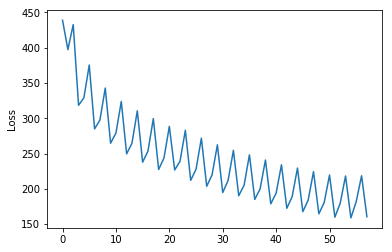

In [51]:
import matplotlib.pyplot as plt

#print("Summary updated loss:", summary_update_loss[:])
#print("Updated loss: ", update_loss)

plt.plot(summary_update_loss[:])
plt.ylabel('Loss')
plt.show()

<h1>Testing the Model</h1>

In [41]:
def text_to_seq(text):
    '''Prepare the text for the model'''
    
    text = clean_text(text, remove_stopwords=True)
    return [vocab_to_int.get(word, vocab_to_int['<UNK>']) for word in text.split()]


In [42]:
count=35
sum_F=12.346860213552002
avg_F=0.3527674346729143


In [43]:
import time


In [61]:
count=count-1
print(count)

43


<h2>The problem with the bellow test code is that even if i give my own review, it doesnt take it as a input. It get some review from the data set itself. I am unable to identify why it is doing so. Please check and let me know.</h2>

In [60]:
count=count+1


##Create your own review or use one from the dataset
#input_sentence = "The packaging and everything was intact, but the yeast I got expired on 12/16.. Not sure if this is still good to use?"
#text = text_to_seq(input_sentence)

##Comment the following 3 lines if using custom Summary and text
random = np.random.randint(0,25389) #len(clean_texts))
input_sentence = clean_texts[random]
text = text_to_seq(clean_texts[random])

print("Cleaned Text", text)

checkpoint = "./best_model.ckpt"

start_time=time.time()

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    ## Load saved model
    loader = tf.train.import_meta_graph(checkpoint + '.meta')
    loader.restore(sess, checkpoint)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    text_length = loaded_graph.get_tensor_by_name('text_length:0')
    summary_length = loaded_graph.get_tensor_by_name('summary_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    
##    Multiply by batch_size to match the model's input parameters
    answer_logits = sess.run(logits, {input_data: [text]*batch_size, 
                                      summary_length: [np.random.randint(5,8)], 
                                      text_length: [len(text)]*batch_size,
                                      keep_prob: 1.0})[0] 

## Remove the padding from the summary
pad = vocab_to_int["<PAD>"] 

elapsed_time=time.time()-start_time

##for custom summary and text, comment this line.
print("Index Value: ",random)

##for custom summary and text use "input_sequence" as parameter insted of "reviews.Text.loc[random]"
print('\nOriginal Text:',reviews.Text.loc[random]) #input_sentence) #

##for custom orignal summary and text uncomment the next line and comment the next to next line.
#ogSum="Expired yeast!"
ogSum=reviews.Summary.loc[random]
ogFile=open("C:/Users/Shreyans/OneDrive/Study/Bennett/Sem2/HPC/Project/amazon_fine_food_review_summarizer/system_summaries/text.001.txt",'w')
ogFile.write(ogSum)
print("File Written to text.001.txt")
ogFile.close()

print('\nOrignal Summary: ',ogSum)

print('\nText')
print('  Word Ids:    {}'.format([i for i in text]))
print('  Input Words: {}'.format(" ".join([int_to_vocab[i] for i in text])))

print('\nSummary')
print('  Word Ids:       {}'.format([i for i in answer_logits if i != pad]))

predSum=" ".join([int_to_vocab[i] for i in answer_logits if i != pad])
predFile=open("C:/Users/Shreyans/OneDrive/Study/Bennett/Sem2/HPC/Project/amazon_fine_food_review_summarizer/model_summaries/text.A.001.txt",'w')
predFile.write(predSum)
print("File Written to text.A.001.txt")
predFile.close()

print("  Response Words: ",predSum)
print("Time: ", elapsed_time)

Cleaned Text [328, 7836, 523, 13, 1153, 611, 4044, 61, 3292, 333, 113, 3233, 3, 2487, 812, 468, 113, 13, 2138, 2139, 760, 4888, 1619, 113, 3233, 3, 1411, 1381, 61, 460]
INFO:tensorflow:Restoring parameters from ./best_model.ckpt
Index Value:  2805

Original Text: This arrived earlier than expected, which was great! However, for some reason, this particular product smelled a little like "fish food".... but no worries, still tasted like great cashew butter, just the smell was kinda weird - like fish food. Also, I wish this product was organic.
File Written to text.001.txt

Orignal Summary:  I love cashew butter!

Text
  Word Ids:    [328, 7836, 523, 13, 1153, 611, 4044, 61, 3292, 333, 113, 3233, 3, 2487, 812, 468, 113, 13, 2138, 2139, 760, 4888, 1619, 113, 3233, 3, 1411, 1381, 61, 460]
  Input Words: arrived earlier expected great however reason particular product smelled little like fish food worries still tasted like great cashew butter smell kinda weird like fish food also wish produc

<h1>Evaluation using ROUGE Scores</h1>
Following code is from https://stackoverflow.com/questions/47045436/how-to-install-the-python-package-pyrouge-on-microsoft-windows/47045437#47045437.
To use ROUGE, you need to install python wrapper for ROUGE. The processes to install it is given in above link.
OR 
You can try and use this package from this link(code is also given) https://github.com/pcyin/PyRouge

from pyrouge import Rouge155
r = Rouge155()



r.system_dir = 'C:/Users/shrey/OneDrive/Study/Bennett/Sem2/HPC/Project/amazon_fine_food_review_summarizer/system_summaries'
r.model_dir = 'C:/Users/shrey/OneDrive/Study/Bennett/Sem2/HPC/Project/amazon_fine_food_review_summarizer/model_summaries'
r.system_filename_pattern = 'text.001.txt'
r.model_filename_pattern = 'text.A.001.txt'

print(r.system_filename_pattern)

output = r.convert_and_evaluate()

print("checkpoint")
print(output)
output_dict = r.output_to_dict(output)

The following code is for calculating ROUGE Score

In [45]:
from __future__ import division
from itertools import chain


def get_unigram_count(tokens):
    count_dict = dict()
    for t in tokens:
        if t in count_dict:
            count_dict[t] += 1
        else:
            count_dict[t] = 1

    return count_dict


class Rouge:
    beta = 1

    @staticmethod
    def my_lcs_grid(x, y):
        n = len(x)
        m = len(y)

        table = [[0 for i in range(m + 1)] for j in range(n + 1)]

        for j in range(m + 1):
            for i in range(n + 1):
                if i == 0 or j == 0:
                    cell = (0, 'e')
                elif x[i - 1] == y[j - 1]:
                    cell = (table[i - 1][j - 1][0] + 1, '\\')
                else:
                    over = table[i - 1][j][0]
                    left = table[i][j - 1][0]

                    if left < over:
                        cell = (over, '^')
                    else:
                        cell = (left, '<')

                table[i][j] = cell

        return table

    @staticmethod
    def my_lcs(x, y, mask_x):
        table = Rouge.my_lcs_grid(x, y)
        i = len(x)
        j = len(y)

        while i > 0 and j > 0:
            move = table[i][j][1]
            if move == '\\':
                mask_x[i - 1] = 1
                i -= 1
                j -= 1
            elif move == '^':
                i -= 1
            elif move == '<':
                j -= 1

        return mask_x

    @staticmethod
    def rouge_l(cand_sents, ref_sents):
        lcs_scores = 0.0
        cand_unigrams = get_unigram_count(chain(*cand_sents))
        ref_unigrams = get_unigram_count(chain(*ref_sents))
        for cand_sent in cand_sents:
            cand_token_mask = [0 for t in cand_sent]
            cand_len = len(cand_sent)
            for ref_sent in ref_sents:
                # aligns = []
                # Rouge.lcs(ref_sent, cand_sent, aligns)
                Rouge.my_lcs(cand_sent, ref_sent, cand_token_mask)

                # for i in aligns:
                #     ref_token_mask[i] = 1
            # lcs = []
            cur_lcs_score = 0.0
            for i in range(cand_len):
                if cand_token_mask[i]:
                    token = cand_sent[i]
                    if cand_unigrams[token] > 0 and ref_unigrams[token] > 0:
                        cand_unigrams[token] -= 1
                        ref_unigrams[token] -= 1
                        cur_lcs_score += 1

                        # lcs.append(token)

            # print ' '.join(lcs)

            lcs_scores += cur_lcs_score

        # print "lcs_scores: %d" % lcs_scores
        ref_words_count = sum(len(s) for s in ref_sents)
        # print "ref_words_count: %d" % ref_words_count
        cand_words_count = sum(len(s) for s in cand_sents)
        # print "cand_words_count: %d" % cand_words_count

        precision = lcs_scores / cand_words_count
        recall = lcs_scores / ref_words_count
        f_score = (1 + Rouge.beta ** 2) * precision * recall / (recall +
                                                                Rouge.beta ** 2 * precision + 1e-7) + 1e-6  # prevent underflow
        return precision, recall, f_score

    # @staticmethod
    # def rouge_2(cand_sents, ref_sents):
    #     cand_bigram_counts = get_bigram_counts(cand_sents)
    #     ref_bigram_counts = get_bigram_counts(ref_sents)




if __name__ == '__main__':
    r = Rouge()
    #A simple eample of how rouge can be calculated
    print(r.rouge_l([[1, 7, 6, 7, 5], [0, 2, 8, 3, 5]],
                    [[1, 2, 3, 4, 5], [3, 9, 5]]))

    #A more practical example of how it can be used for summary evaluation
    system_generated_summary = " The Kyrgyz President pushed through the law requiring the use of ink during the upcoming Parliamentary and Presidential elections In an effort to live up to its reputation in the 1990s as an island of democracy. The use of ink is one part of a general effort to show commitment towards more open elections. improper use of this type of ink can cause additional problems as the elections in Afghanistan showed. The use of ink and readers by itself is not a panacea for election ills."
    manual_summmary = " The use of invisible ink and ultraviolet readers in the elections of the Kyrgyz Republic which is a small, mountainous state of the former Soviet republic, causing both worries and guarded optimism among different sectors of the population. Though the actual technology behind the ink is not complicated, the presence of ultraviolet light (of the kind used to verify money) causes the ink to glow with a neon yellow light. But, this use of the new technology has caused a lot of problems. "

    print(r.rouge_l([system_generated_summary], [manual_summmary]))

In [62]:
r = Rouge()

system_generated_summary = ogSum
manual_summmary = predSum

[precision, recall, f_score] = r.rouge_l([system_generated_summary], [manual_summmary])

print("Precision is :"+str(precision)+"\nRecall is :"+str(recall)+"\nF Score is :"+str(f_score))

sum_F=sum_F+f_score
avg_F=sum_F/count

print("Sum of ROUGE Score: ",sum_F)
print("Average ROUGE Score = ", avg_F)

print("Count: ",count)

Precision is :0.38095238095238093
Recall is :0.25
F Score is :0.30188774460662915
Sum of ROUGE Score:  14.068020212266791
Average ROUGE Score =  0.3271632607503905
Count:  43
